# <span style="font-weight:bold; color:#252525">TESTE TÉCNICO - </span> <span><img src="https://www.lopes.com.br/assets/img/common/logo-lopes-hd.png" alt="Lopes Labs" style="display:inline; vertical-align:baseline;height:24px;"></img></span>

## Contexto

O presente problema se refere aos dados de vinhos portugueses
"Vinho Verde", que possuem variantes de vinho branco e tinto.
Devido a questões de privacidade, apenas variáveis
físico-químicas (input) e sensoriais (output) estão disponíveis (por
exemplo, não há dados sobre tipo de uva, marca do vinho, preço
de venda, etc).

## Objetivo
Criar um modelo para estimar a qualidade do vinho.

## 0.0 Importação dos módulos

In [ ]:
import warnings
import functools

import numpy as np
import pandas as pd
import ppscore as pps

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import balanced_accuracy_score, f1_score, log_loss,\
precision_score, recall_score, roc_auc_score, matthews_corrcoef

from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import classification_report, confusion_matrix,\
roc_auc, precision_recall_curve, class_prediction_error
from yellowbrick.style import set_palette
import shap

import optuna

### 0.1 Definição de constantes

In [2]:
# Constantes de diretórios do projeto
PROJECT_DIR = str(Path().resolve()).rpartition('/')[0]
DATA_DIR = PROJECT_DIR + "/data"

### 0.2 Setup de variáveis de ambiente e módulos

In [3]:
%matplotlib inline
sns.set(style="ticks", color_codes=True)

set_palette('flatui')

shap.initjs()

warnings.filterwarnings('ignore')

## 1.0 Preparação dos dados

### 1.1 Carregamento dos dados 

In [4]:
# Dataframe da fonte de dados primária
df_raw = pd.read_csv(DATA_DIR + '/raw/winequality.csv', sep=';')

# Como não se tratam de dados de eventos, removeremos os duplicados da análise
df_raw.drop_duplicates(inplace=True)
df_raw.reset_index(inplace=True, drop=True)

# Algumas informações sobre o dataset
print('Número de linhas:', df_raw.shape[0])
print('Número de atributos:', df_raw.shape[1] - 1)

# Tabela com cinco linhas aleatórias do dataset
df_raw.sample(frac=1).head()

Número de linhas: 5320
Número de atributos: 12


type  fixed acidity  volatile acidity  citric acid  residual sugar  \
1220  White            8.0              0.25         0.49             1.2   
3710  White            6.5              0.29         0.32             3.0   
1833  White            6.6              0.23         0.24             3.9   
3299  White            6.7              0.24         0.30            10.2   
2958  White            6.4              0.37         0.20             5.6   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
1220      0.061                 27.0                 117.0  0.99380  3.08   
3710      0.036                 38.0                  93.0  0.99060  3.16   
1833      0.045                 36.0                 138.0  0.99220  3.15   
3299      0.070                 44.0                 179.0  0.99666  2.86   
2958      0.117                 61.0                 183.0  0.99459  3.24   

      sulphates alcohol  quality  
1220       0.34     9.4        5  
3710       0.59      12        6  
1833       0.64    11.3        7  
3299       0.46     8.9        6  
2958       0.43     9.5        5

### 1.2 Busca por dados faltantes

In [5]:
df_with_nulls = df_raw[pd.isnull(df_raw).any(axis=1)]

if df_with_nulls.shape[0] == 0:
    print("Não existem linhas com valores faltantes!")
else:
    print(df_with_nulls)

Não existem linhas com valores faltantes!


<b>>>> Como não existem dados faltantes, nenhuma técnica de preenchimento será aplicada.</b>

### 1.3 Verificação de consistência de tipos nas colunas

In [6]:
df_raw.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
quality                   int64
dtype: object

Como podemos observar, a coluna "alcohol" parece apresentar alguns valores que forçaram o casting de float para object.
Também conseguimos ver que os valores dessa coluna não apresentam precisão acima de dois dígitos. Então vamos verificar os casos possíveis:

In [7]:
# Tamanho médio da maior parte das strings (arredondado para cima, somando 1 por conta do separador '.')
avg_length_ceil = np.ceil(np.mean([len(str(v)) for v in df_raw.alcohol.values])) + 1

# Lista de valores em desacordo
weired_values = [v for v in df_raw.alcohol.values if len(str(v)) > avg_length_ceil]
print(
    "Número de registros em desacordo:",
    len(weired_values),
    "(%.2f%%)" % (len(weired_values) / df_raw.shape[0])
)

# Conjunto de valores com valores fora do padrão
set([v for v in df_raw.alcohol.values if len(str(v)) > avg_length_ceil])

Número de registros em desacordo: 32 (0.01%)


{'100.333.333.333.333',
 '101.333.333.333.333',
 '104.666.666.666.667',
 '105.333.333.333.333',
 '105.666.666.666.667',
 '109.333.333.333.333',
 '109.666.666.666.667',
 '110.666.666.666.667',
 '112.666.666.666.667',
 '113.333.333.333.333',
 '113.666.666.666.667',
 '114.333.333.333.333',
 '114.666.666.666.667',
 '116.333.333.333.333',
 '117.333.333.333.333',
 '120.666.666.666.667',
 '123.333.333.333.333',
 '128.933.333.333.333',
 '131.333.333.333.333',
 '135.666.666.666.667',
 '923.333.333.333.333',
 '953.333.333.333.333',
 '956.666.666.666.667',
 '963.333.333.333.333',
 '973.333.333.333.333'}

Aparentemente no processamento ou exportação do dataset houve algum problema de tipo nesta coluna. Vamos assumir uma estratégia de substituir estes valores pela mediana de cada classe correspondente, já que o percentual de valores inconsistentes é bem baixo. Considerando também a hipótese de que o grau alcoólico dos vinhos geralmente não é muito alto.

In [8]:
# Identifica os valores incorreto e substitui por nulo
df_raw['alcohol_'] = df_raw.alcohol.apply(
    lambda x: np.nan
    if len(str(x)) > avg_length_ceil
    else float(x)
)

# Medianas por tipo de vinho
median_by_type = df_raw.groupby(['type']).median()[['alcohol_']].to_dict(orient='index')

# Valores substituídos por tipo de vinho em cada lista
alcohol__ = []
for wtype in median_by_type.keys():
    alcohol__.append(np.where(
        (df_raw.type == wtype) & (df_raw.alcohol_.isnull()),
        median_by_type[wtype]['alcohol_'],
        df_raw['alcohol_']
    ))

# Compressão das listas em apenas uma, substituindo os valores nulos de cada uma
df_raw['alcohol'] = np.nanmean(alcohol__, axis=0)

df_raw.drop(['alcohol_'], axis=1, inplace=True)

In [9]:
df_raw.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Com a heurística acima conseguimos corrigir os valores da coluna "alcohol"

## 2.0 Análise dos dados

### 2.1 Correlação entre as features

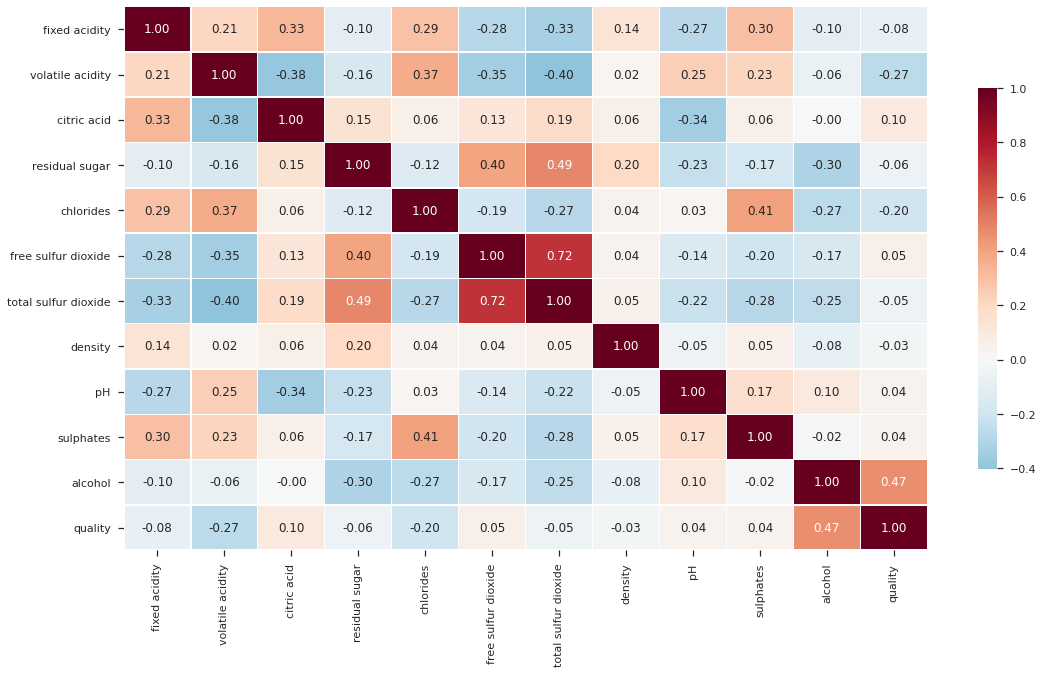

In [10]:
# Matriz da correlação de Pearson das features
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(
    df_raw.corr(),
    vmax=1.0,
    center=0,
    fmt='.2f',
    square=False,
    linewidths=.5,
    annot=True,
    cbar_kws={"shrink": .70},
    cmap="RdBu_r"
)

plt.show()

Podemos observar que existe uma correlação entre as features que estão ligadas ao enxofre (sulfatos, ácidos e o pH). Existe também uma correção entre os açúcares residuais e os dióxidos de enxofre, que fazem parte do processo de fermentação alcoólica do vinho.

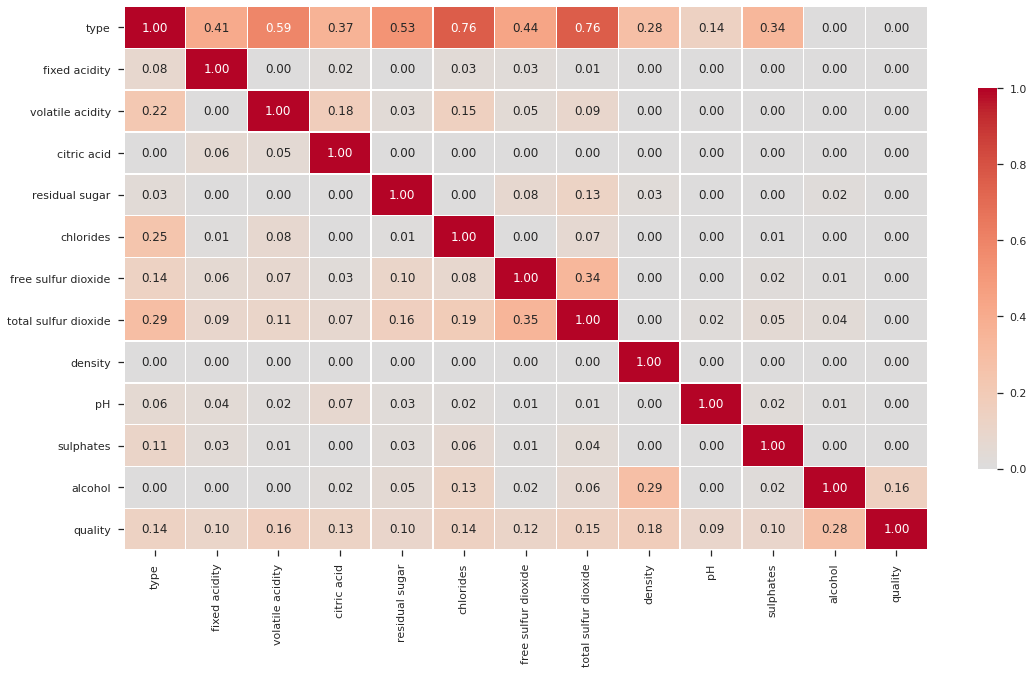

In [11]:
# Matriz da Predictive Power Score das features
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(
    pps.matrix(df_raw),
    vmax=1.0,
    center=0,
    fmt='.2f',
    square=False,
    linewidths=.5,
    annot=True,
    cbar_kws={"shrink": .70},
    cmap="coolwarm"
)

plt.show()

Com o uso do Predictive Power Score, descobrimos que as features mais relevantes para a predição são o álcool, a densidade e acidez volátil, considerando uma análise univariada na linha de qualidade da matriz. Também conseguimos observar que algumas propriedades do vinho são responsáveis por tornar ele branco ou tinto.

### 2.2 Detecção de outliers

In [12]:
# Apenas colunas de features
features_columns = [c for c in df_raw.columns if c not in ('type', 'quality')]

# Uso do algoritmo de Isolation Forest para detecção da quantidade de outliers
clf = IsolationForest(
    random_state=42,
    contamination='auto',
    n_jobs=-1
)

preds = clf.fit_predict(df_raw[features_columns].values)

print("Porcentagem de outliers na base: %.2f%%" % ((list(preds).count(-1) / df_raw.shape[0]) * 100))

Porcentagem de outliers na base: 6.32%


Como a proporção de outliers é maior do que 5%, precisamos escolher uma estratégia que leve em consideração esse fator na modelagem.

## 3.0 Pré-processamento

In [13]:
# Copia integral do dataset original
df = df_raw.copy()

# Colunas de interesse do dataset
features_columns = [c for c in df.columns if c != 'quality']
target_column = 'quality'

print("Features:", features_columns)
print("Target:", target_column)

Features: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Target: quality


### 3.1 Transformação das variáveis categóricas

In [14]:
# Pivot das classes em colunas
df[['type_red', 'type_white']] = pd.get_dummies(df['type'].values)
#df.drop(['type'], axis=1, inplace=True)

# Colunas de interesse do dataset
features_columns = [c for c in df.columns if c != 'quality' and 'type_' not in c]

df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  White            7.0              0.27         0.36            20.7   
1  White            6.3              0.30         0.34             1.6   
2  White            8.1              0.28         0.40             6.9   
3  White            7.2              0.23         0.32             8.5   
4  White            6.2              0.32         0.16             7.0   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.045                 30.0                 136.0   0.9949  3.18   

   sulphates  alcohol  quality  type_red  type_white  
0       0.45      8.8        6         0           1  
1       0.49      9.5        6         0           1  
2       0.44     10.1        6         0           1  
3       0.40      9.9        6         0           1  
4       0.47      9.6        6         0           1

### 3.2 Feature engineering

#### 3.2.1 Distribuição das labels

Primeiro, vamos ver a distribuição das labels para identificar o padrão.

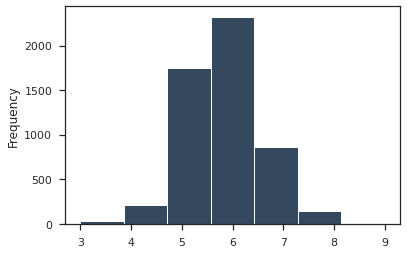

In [15]:
# Distribuição dos valores de target
df.quality.plot.hist(bins=df.quality.nunique())

Pelo histograma acima, podemos inferir que a distribuição é do tipo normal. Contudo, não conseguirmos inferir com tanta certeza a distribuição exata da população. Para isso, vamos gerar uma população normal com mais pontos que o dataset nos fornece.

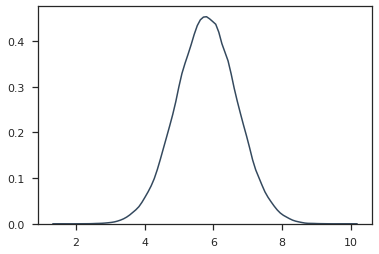

In [16]:
# Distribuição normal com 100k pontos
norm_dist = np.random.normal(df.quality.mean(), df.quality.std(), 100000)

# Gráfico da distribuição normal
sns.kdeplot(norm_dist)

Vamos assumir que os vinhos de baixa qualidade representam 80% da amostra. Assim, pelos quantils da distribuição, podemos assumir um valor de corte entre as qualidades de vinho.

In [17]:
# Valores encontrados pelo quantil 0.8:
thresh_sample = round(np.quantile(df.quality, q=0.80))
thresh_norm = round(np.quantile(norm_dist, q=0.80))

print("Valor baseado na distribuição do dataset:", thresh_sample)
print("Valor baseado na distribuição normal", thresh_norm)

# Valores acima e abaixo do quantil:
sample_lower = df[df.quality < thresh_sample].shape[0]
sample_upper = df[df.quality >= thresh_sample].shape[0]
normal_lower = df[df.quality < thresh_norm].shape[0]
normal_upper = df[df.quality >= thresh_norm].shape[0]

print('---')
print("Dataset \t abaixo: %s | acima: %s" % (sample_lower, sample_upper))
print("Normal  \t abaixo: %s | acima: %s" % (normal_lower, normal_upper))

Valor baseado na distribuição do dataset: 6.0
Valor baseado na distribuição normal 7.0
---
Dataset 	 abaixo: 1988 | acima: 3332
Normal  	 abaixo: 4311 | acima: 1009


Como o fator de corte para o dataset gerou uma distribuição conflitante com o estabelecido, uma vez que esperávamos que o número de exemplos abaixo fosse maior, vamos utilizar o fator da distribuição normal.

In [18]:
df['quality_top'] = df.quality.apply(lambda x: 0 if x < thresh_norm else 1)
df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  White            7.0              0.27         0.36            20.7   
1  White            6.3              0.30         0.34             1.6   
2  White            8.1              0.28         0.40             6.9   
3  White            7.2              0.23         0.32             8.5   
4  White            6.2              0.32         0.16             7.0   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.045                 30.0                 136.0   0.9949  3.18   

   sulphates  alcohol  quality  type_red  type_white  quality_top  
0       0.45      8.8        6         0           1            0  
1       0.49      9.5        6         0           1            0  
2       0.44     10.1        6         0           1            0  
3       0.40      9.9        6         0           1            0  
4       0.47      9.6        6         0           1            0

#### 2.2.2 Novos atributos associados ao contexto 

In [19]:
# Relações inferidas acerca de algumas variáveis
df['alcohol per pH'] = df['alcohol'] / df['pH']
df['consumed sulfur dioxide'] = df['total sulfur dioxide'] - df['free sulfur dioxide']
df['alcohol per fixed acidity'] = df['alcohol'] / df['fixed acidity']
df['alcohol and volatile acidity'] = df['alcohol'] * df['volatile acidity']
df['sulphates per chlorides'] = df['sulphates'] / df['chlorides']
df['free sulfur dioxide per residual sugar'] = df['free sulfur dioxide'] / df['residual sugar']

# Atualização das colunas de interesse do dataset
features_columns = [c for c in df.columns if c not in ('type', 'quality') and '_' not in c]

df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  White            7.0              0.27         0.36            20.7   
1  White            6.3              0.30         0.34             1.6   
2  White            8.1              0.28         0.40             6.9   
3  White            7.2              0.23         0.32             8.5   
4  White            6.2              0.32         0.16             7.0   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  ...  \
0      0.045                 45.0                 170.0   1.0010  3.00  ...   
1      0.049                 14.0                 132.0   0.9940  3.30  ...   
2      0.050                 30.0                  97.0   0.9951  3.26  ...   
3      0.058                 47.0                 186.0   0.9956  3.19  ...   
4      0.045                 30.0                 136.0   0.9949  3.18  ...   

   quality  type_red  type_white  quality_top  alcohol per pH  \
0        6         0           1            0        2.933333   
1        6         0           1            0        2.878788   
2        6         0           1            0        3.098160   
3        6         0           1            0        3.103448   
4        6         0           1            0        3.018868   

   consumed sulfur dioxide  alcohol per fixed acidity  \
0                    125.0                   1.257143   
1                    118.0                   1.507937   
2                     67.0                   1.246914   
3                    139.0                   1.375000   
4                    106.0                   1.548387   

   alcohol and volatile acidity  sulphates per chlorides  \
0                         2.376                10.000000   
1                         2.850                10.000000   
2                         2.828                 8.800000   
3                         2.277                 6.896552   
4                         3.072                10.444444   

   free sulfur dioxide per residual sugar  
0                                2.173913  
1                                8.750000  
2                                4.347826  
3                                5.529412  
4                                4.285714  

[5 rows x 22 columns]

### 3.3 Normalização do intervalo de valores

In [20]:
# Uso do PowerTransformer por conta dos outliers vistos na análise do dataset
scaler = PowerTransformer()
scaler.fit(df[features_columns].values)

# Aplicação da transformação no dataset
df[features_columns] = scaler.transform(df[features_columns].values)

df.head(3)

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  White       0.008647         -0.301436     0.324541        1.822782   
1  White      -0.710116         -0.040458     0.190631       -0.969440   
2  White       0.858739         -0.211116     0.587665        0.869169   

   chlorides  free sulfur dioxide  total sulfur dioxide   density        pH  \
0  -0.240386             0.904940              0.974020  0.352203 -1.483840   
1  -0.013523            -0.903830              0.352350 -0.163606  0.521768   
2   0.040016             0.171636             -0.248585 -0.079863  0.280302   

   ...  quality  type_red  type_white  quality_top  alcohol per pH  \
0  ...        6         0           1            0       -0.904790   
1  ...        6         0           1            0       -1.104752   
2  ...        6         0           1            0       -0.355863   

   consumed sulfur dioxide  alcohol per fixed acidity  \
0                 0.893860                  -0.770404   
1                 0.758884                   0.090881   
2                -0.294386                  -0.808374   

   alcohol and volatile acidity  sulphates per chlorides  \
0                     -0.695622                -0.098584   
1                     -0.261415                -0.098584   
2                     -0.279663                -0.407525   

   free sulfur dioxide per residual sugar  
0                               -1.364694  
1                                0.294207  
2                               -0.546122  

[3 rows x 22 columns]

### 3.4 Pairplot das features transformadas

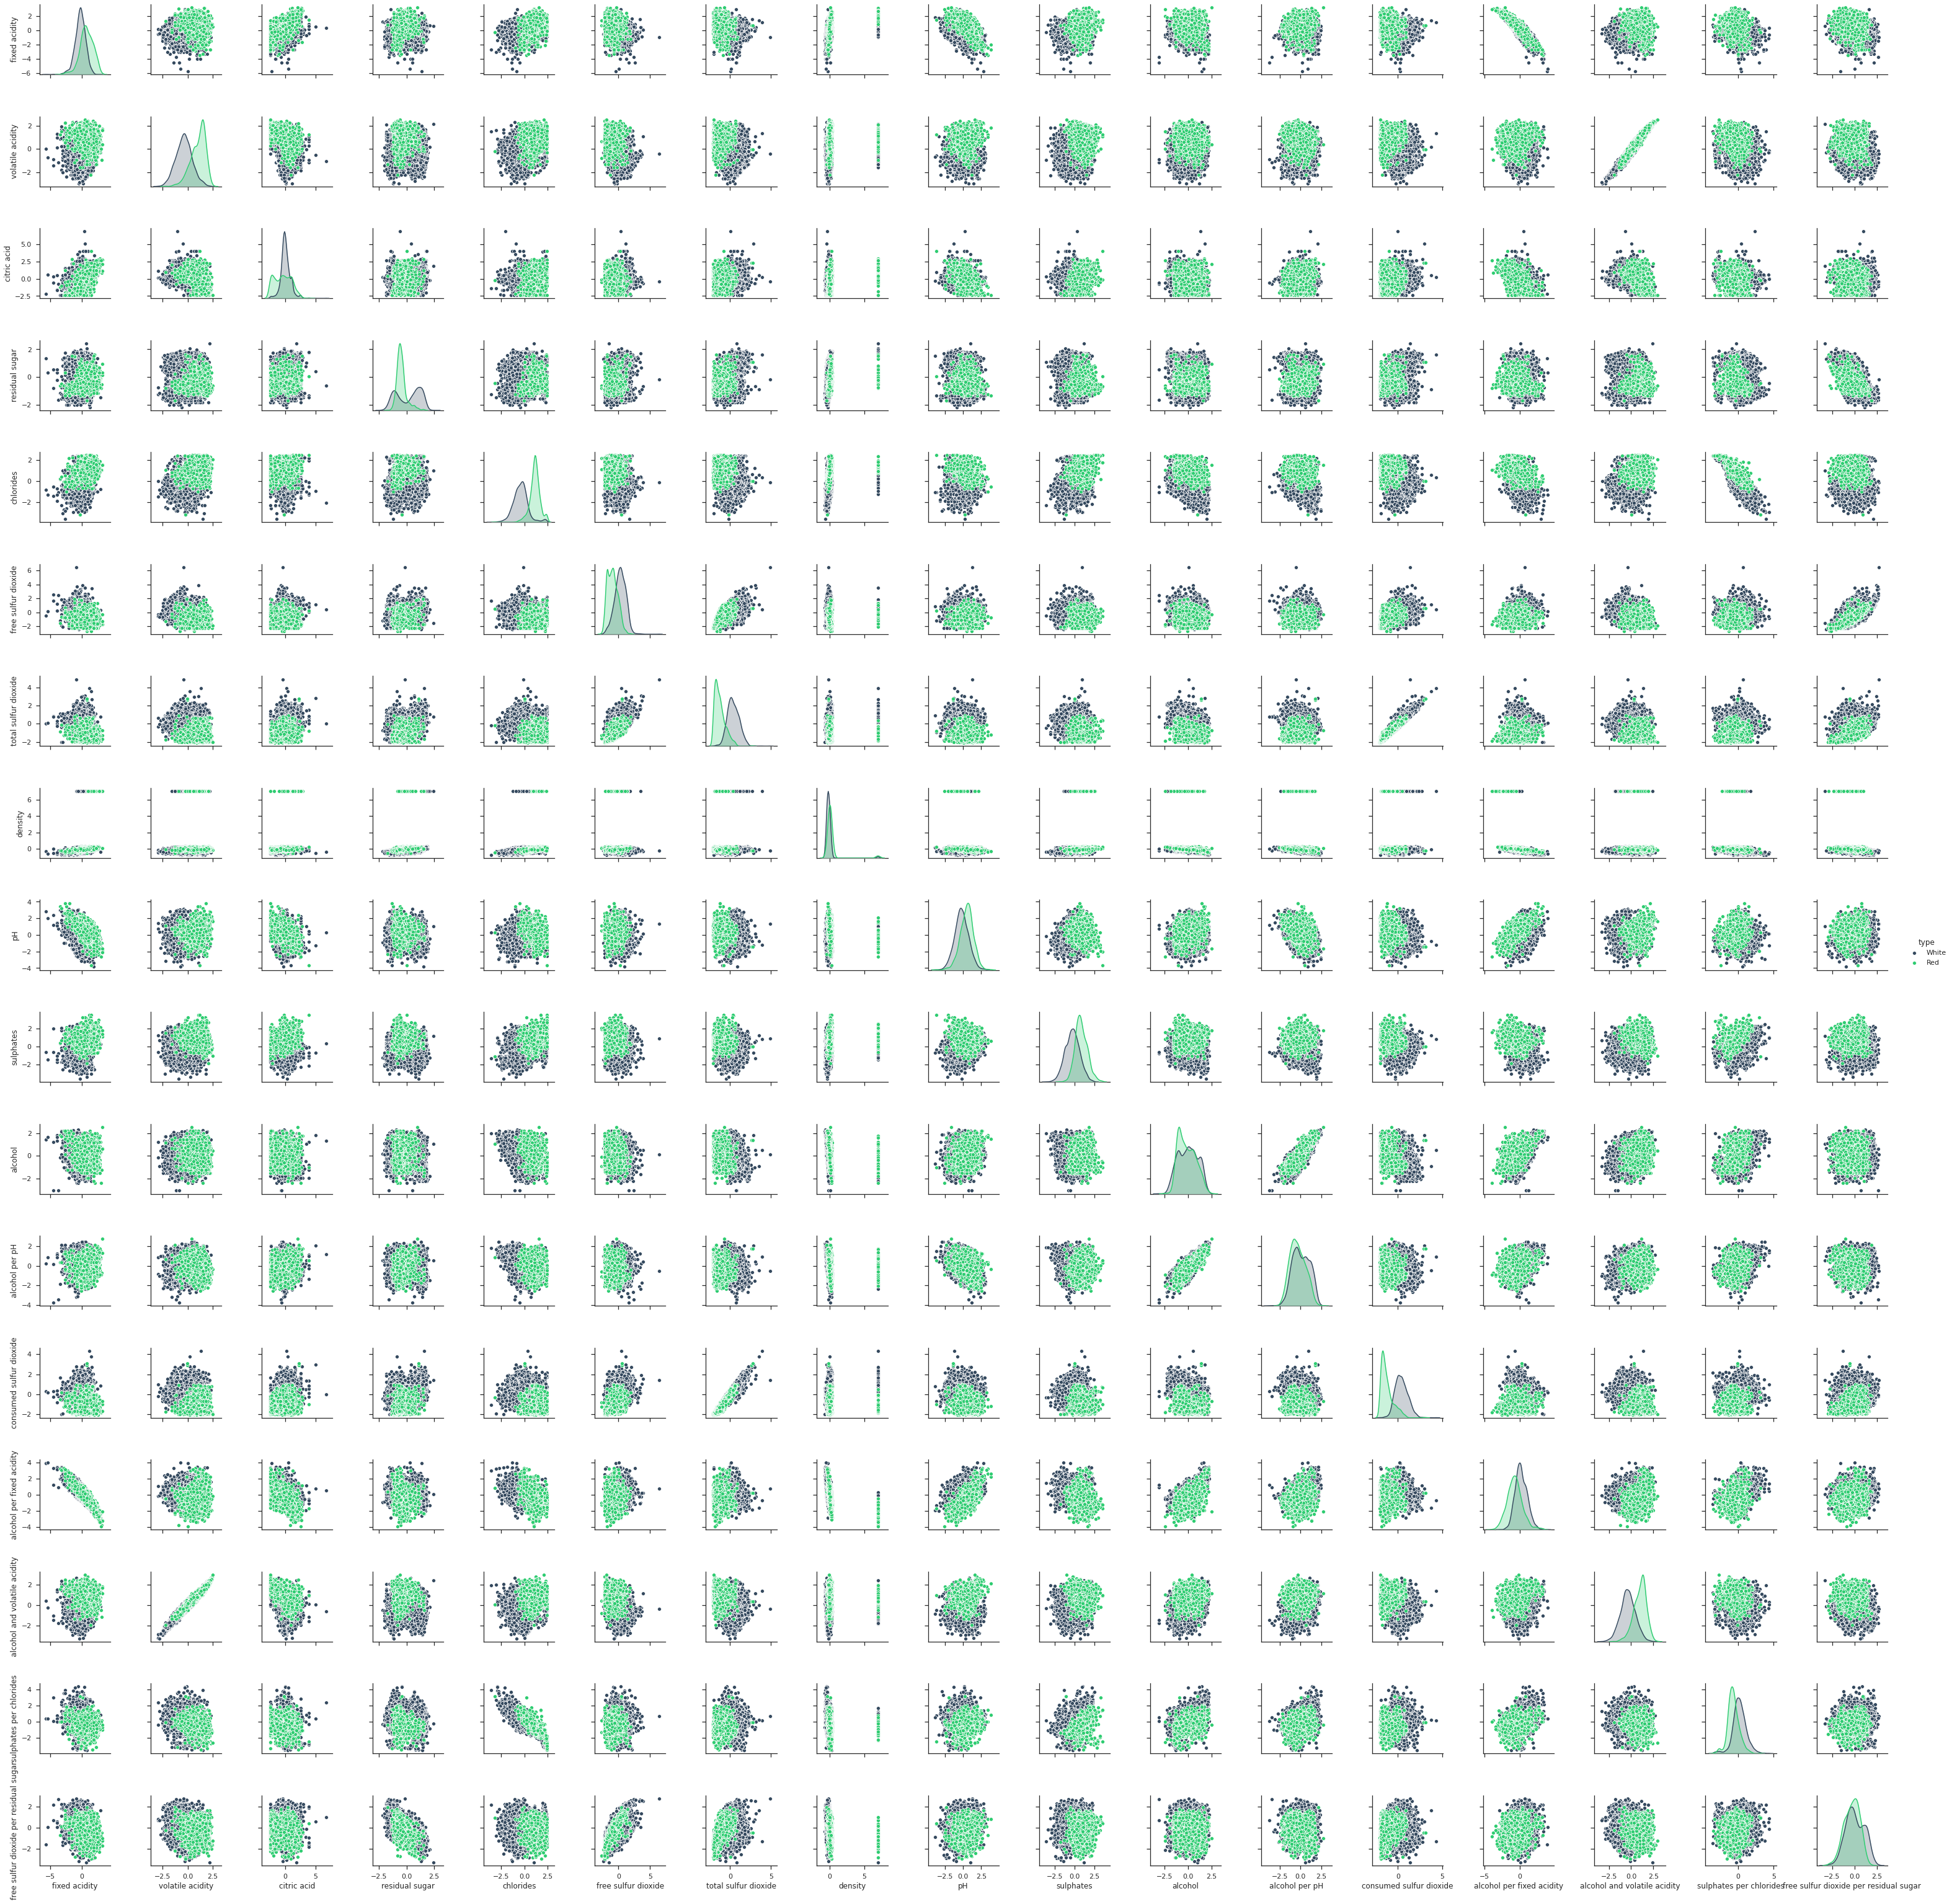

In [21]:
sns.pairplot(df, vars=features_columns, hue='type')

## 4.0 Treino e teste

### 4.1 Cálculo dos racionais para separação do dataset

In [22]:
# Quantidade de exemplos por classe
value_counts = df[[c for c in df.columns if 'type_' in c]].sum()
print("Contagem de exemplos por classe:", value_counts.to_dict())

# Racional entre uma classe e outra
ratio = value_counts.max() / value_counts.min()
print("Racional entre a maior e a menor classe: %.2f" % ratio)

Contagem de exemplos por classe: {'type_red': 1359, 'type_white': 3961}
Racional entre a maior e a menor classe: 2.91


A distribuição não é uniforme, vamos atribuir algumas labels para nos ajudar a separar em quartils. Assim podemos usá-los na hora de realizar a separação e garantir a mesma proporção da distribuição normal acima

In [23]:
# Realiza o cálculo para a existência de no máximo dez intervalos
intervals = pd.qcut(x=df.quality.values, q=10, duplicates='drop', labels=False)

df['quality_bin'] = intervals
print("Contagem por intervalo:", df.quality_bin.value_counts().to_dict())

df.sample(frac=1).head()

Contagem por intervalo: {1: 2323, 0: 1988, 2: 856, 3: 153}


type  fixed acidity  volatile acidity  citric acid  residual sugar  \
2313  White       0.008647         -0.301436     1.096226        0.735497   
2950  White      -0.179780         -1.570634    -0.943042       -0.810587   
844   White      -0.084026         -0.594301     0.522458       -1.246248   
3978    Red       0.724196          0.117858     1.281227       -0.810587   
607   White      -1.075993         -0.040458     0.844794       -1.056055   

      chlorides  free sulfur dioxide  total sulfur dioxide   density  \
2313  -0.424753             1.506864              1.196706 -0.037623   
2950  -0.181703             0.226351              0.047301 -0.298188   
844    0.635555            -0.588012              0.419126 -0.256141   
3978   2.445700            -0.662962             -1.004706  0.054975   
607   -0.181703            -0.820612              1.165080 -0.121606   

            pH  ...  type_red  type_white  quality_top  alcohol per pH  \
2313 -0.095868  ...         0           1            0       -0.889913   
2950  0.341351  ...         0           1            0        0.226473   
844   0.581012  ...         0           1            1       -0.222559   
3978 -1.188471  ...         1           0            0       -0.585466   
607   1.627636  ...         0           1            0       -0.770792   

      consumed sulfur dioxide  alcohol per fixed acidity  \
2313                 0.874690                  -0.461486   
2950                 0.051795                   0.341407   
844                  0.758884                   0.088679   
3978                -0.953922                  -1.123202   
607                  1.669771                   0.767463   

      alcohol and volatile acidity  sulphates per chlorides  \
2313                     -0.536857                 0.337780   
2950                     -1.475381                 0.348857   
844                      -0.576894                -0.744505   
3978                     -0.185274                -2.529951   
607                      -0.050187                 0.206464   

      free sulfur dioxide per residual sugar  quality_bin  
2313                                0.431609            1  
2950                                1.066252            1  
844                                 0.824080            2  
3978                                0.384056            1  
607                                 0.450905            0  

[5 rows x 23 columns]

### 4.2 Separação do dataset em treino e teste

In [24]:
# Colunas de interesse do dataset
features_columns = [c for c in df.columns if c not in ('type', 'quality')]
target_column = 'quality'

# Separação das classes
df_white = df[df.type_white == 1]
df_red = df[df.type_red == 1]

# Treino e teste para cada classe
# > Vinho branco:
train_w, test_w = train_test_split(
    df_white,
    train_size=0.5,
    random_state=42,
    stratify=df_white.quality_bin
)
# > Vinho branco:
train_r, test_r = train_test_split(
    df_red,
    train_size=0.5,
    random_state=42,
    stratify=df_red.quality_bin
)

# Junção das classes nos datasets separados
train = pd.concat([train_w, train_r]).sample(frac=1)
test = pd.concat([test_w, test_r]).sample(frac=1)

# Remove a label auxiliar da lista de atributos
features_columns.remove('quality_bin')

# Arrays de treinamento e test com o target a parte
# > treino:
X_train_ = train[features_columns].values
y_train_ = train[target_column].values
# > teste:
X_test = test[features_columns].values
y_test = test[target_column].values

# Verificação de consistência dos dados
assert len(X_train_) + len(X_test) == df.shape[0]

print("Exemplos de treino:", len(X_train_))
print("Exemplos de teste:", len(X_test))

Exemplos de treino: 2659
Exemplos de teste: 2661


### 4.3 Resampling da partição de treino

In [25]:
label_counts = pd.Series(y_train_).value_counts().to_dict()
print("Exemplos por label (treino):", label_counts)

# Estratégia de oversampling
ose = SMOTE(
    k_neighbors=min(list(label_counts.values())) - 1,
    random_state=42
)

# Estratégia de undersampling
use = EditedNearestNeighbours(
    n_neighbors=min(list(label_counts.values())) - 1
)

# Estratégia hibrida
sme = SMOTEENN(
    random_state=42,
    n_jobs=-1,
    smote=ose,
    enn=use
)
X_train, y_train = sme.fit_resample(X_train_, y_train_)

print("Exemplos por label (oversample):", pd.Series(y_train).value_counts().to_dict())

print('---')
print("Exemplos do dataset\t", "original: %s" % len(X_train_), "oversample: %s" % len(X_train))

samples_ratio = round((len(X_train)/len(X_train_)), 2)
print("Proporção:", samples_ratio)

Exemplos por label (treino): {6: 1161, 5: 886, 7: 427, 4: 95, 8: 74, 3: 13, 9: 3}
Exemplos por label (oversample): {3: 1161, 9: 1161, 8: 1161, 4: 1157, 7: 1084, 5: 649, 6: 449}
---
Exemplos do dataset	 original: 2659 oversample: 6822
Proporção: 2.57


### 4.4 Escolha de modelos candidatos

In [26]:
# Função genérica de treino e métricas
def train_classifier(classifier, kargs, X_train, y_train, X_test, y_test, return_scores=False):
    # Recupera o nome da classe
    name = classifier.__name__
    
    # Conjunto das labels do input
    labels = list(set(np.append(y_train, y_test)))
    
    # Treinamento do modelo
    clf = classifier(**kargs)
    clf.fit(X_train, y_train)
    
    # Predições
    preds = clf.predict(X_test) if 'predict' in dir(clf) else None
    preds_proba = clf.predict_proba(X_test) if 'predict_proba' in dir(clf) else None
    
    # Métricas
    accuracy = balanced_accuracy_score(y_test, preds) if preds is not None else np.nan
    precision = precision_score(y_test, preds, average='weighted') if preds is not None else np.nan
    recall = recall_score(y_test, preds, average='weighted') if preds is not None else np.nan
    f1 = f1_score(y_test, preds, average='weighted') if preds is not None else np.nan
    mcc = matthews_corrcoef(y_test, preds) if preds is not None else np.nan
    logloss = log_loss(y_test, preds_proba, labels=labels) if preds_proba is not None else np.nan
    roc_auc = roc_auc_score(y_test, preds_proba, average='weighted', multi_class='ovr', labels=labels) if preds_proba is not None else np.nan
    
    if return_scores:
        scores = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "mcc": mcc,
            "logloss": logloss,
            "roc_auc": roc_auc
        }
        return clf, scores
    else:
        print(
            "%s: \n Accuracy: %.3f | Precision: %.3f | Recall: %.3f | F1: %.3f | MCC: %.3f | Logloss: %.3f | ROC_AUC: %.3f" %\
            (name, accuracy, precision, recall, f1, mcc, logloss, roc_auc)
        )
        return clf 

In [27]:
%%time

# Teste de algoritmos diversos antes da escolha

# XGBoost
params = {"n_estimators": 100, "objective": "multi:softprob",
          "eval_metric": "mlogloss", "n_jobs": -1, "random_state": 42}
xgb_clf = train_classifier(xgb.XGBClassifier, params, X_train,
                           y_train, X_test, y_test)

# LightGBM
params = {"n_estimators": 100, "objective": "multiclass", "n_jobs": -1,
          "random_state": 42}
lgbm_clf = train_classifier(lgbm.LGBMClassifier, params, X_train,
                           y_train, X_test, y_test)

# CatBoostClassifier
params = {"n_estimators": 100, "objective": "MultiClass", "thread_count": -1,
          "random_seed": 42, "verbose": False}
catb_clf = train_classifier(CatBoostClassifier, params, X_train,
                           y_train, X_test, y_test)

# ExtraTreesClassifier
params = {"n_estimators":100, "class_weight": "balanced_subsample", "n_jobs": -1,
          "random_state": 42}
etree_clf = train_classifier(ExtraTreesClassifier, params, X_train,
                           y_train, X_test, y_test)

# GradientBoostingClassifier
params = {"n_estimators":100, "random_state": 42}
gb_clf = train_classifier(GradientBoostingClassifier, params, X_train,
                           y_train, X_test, y_test)

# KNeighborsClassifier
params = {"n_neighbors": 10, "weights": "distance", "n_jobs": -1}
knn_clf = train_classifier(KNeighborsClassifier, params, X_train,
                           y_train, X_test, y_test)

# MLPClassifier
params = {"activation": "tanh", "learning_rate": "invscaling", "random_state": 42}
mlp_clf = train_classifier(MLPClassifier, params, X_train,
                           y_train, X_test, y_test)

# SVC
params = {"class_weight": "balanced", "probability": True, "random_state": 42}
svm_clf = train_classifier(SVC, params, X_train,
                           y_train, X_test, y_test)

print("---")

XGBClassifier: 
 Accuracy: 0.400 | Precision: 0.663 | Recall: 0.637 | F1: 0.647 | MCC: 0.480 | Logloss: 1.478 | ROC_AUC: 0.839
LGBMClassifier: 
 Accuracy: 0.399 | Precision: 0.669 | Recall: 0.646 | F1: 0.654 | MCC: 0.491 | Logloss: 1.279 | ROC_AUC: 0.845
CatBoostClassifier: 
 Accuracy: 0.408 | Precision: 0.669 | Recall: 0.620 | F1: 0.639 | MCC: 0.468 | Logloss: 1.187 | ROC_AUC: 0.840
ExtraTreesClassifier: 
 Accuracy: 0.408 | Precision: 0.674 | Recall: 0.666 | F1: 0.667 | MCC: 0.515 | Logloss: 0.976 | ROC_AUC: 0.848
GradientBoostingClassifier: 
 Accuracy: 0.370 | Precision: 0.661 | Recall: 0.582 | F1: 0.612 | MCC: 0.429 | Logloss: 1.101 | ROC_AUC: 0.836
KNeighborsClassifier: 
 Accuracy: 0.335 | Precision: 0.573 | Recall: 0.400 | F1: 0.425 | MCC: 0.265 | Logloss: 9.019 | ROC_AUC: 0.722
MLPClassifier: 
 Accuracy: 0.400 | Precision: 0.657 | Recall: 0.603 | F1: 0.623 | MCC: 0.445 | Logloss: 1.528 | ROC_AUC: 0.833
SVC: 
 Accuracy: 0.388 | Precision: 0.667 | Recall: 0.601 | F1: 0.627 | MCC: 0

Por uma análise primárias das métricas de cada modelo sem otimização, verificamos que o algoritmo ExtraTreesClassifier apresentou os melhores resultados. Vamos utilizá-lo na otimização.

### 4.5 Otimização de hiperparâmetros

In [28]:
%%time

# Definição da função de otimização
def objective(classifier, X_train, y_train, X_test, y_test, trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 2000),
        "criterion": trial.suggest_categorical('criterion', ['gini', 'entropy']),
        "max_features": trial.suggest_discrete_uniform('max_features', 0.1, 1.0, 0.1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "n_jobs": -1,
        "class_weight": "balanced",
        "random_state": 42,
    }
    
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    
    metric = matthews_corrcoef(y_test, preds)
    return metric

# Instância do modelo de estudo dos hiperparâmetros
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    direction='maximize'
)

# Configura o nível de verbosidade do Optuna
optuna.logging.set_verbosity(0)

# Otimização dos hiperparâmetros
study.optimize(
    functools.partial(objective, ExtraTreesClassifier, X_train, y_train, X_test, y_test),
    n_trials=100,
    n_jobs=1,
    show_progress_bar=True
)

print("Best score:", study.best_value)
print("Best params:", study.best_params)

print("---")


Best score: 0.5155494067413223
Best params: {'n_estimators': 885, 'criterion': 'gini', 'max_features': 0.2, 'min_samples_leaf': 2}
---
CPU times: user 8min 55s, sys: 19.7 s, total: 9min 15s
Wall time: 2min 31s


### 4.6 Validação cruzada do modelo

In [29]:
# Parâmetros encontrados no estudo e as constantes
params = study.best_params.copy()
params['random_state'] = 42
params['class_weight'] = 'balanced'
params['n_jobs'] = -1

# Dados originais do Dataset
X = df[features_columns].values
y = df[target_column].values

# Validação cruzada do Classificador
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for train_index, test_index in skf.split(X, y):
    _, score = train_classifier(
        ExtraTreesClassifier, params,
        X[train_index], y[train_index],
        X[test_index], y[test_index],
        return_scores=True
    )
    scores.append(score)

# Dataframe com as métricas
scores_df = pd.DataFrame(scores)
scores_df.describe().drop(index='count')

accuracy  precision    recall        f1       mcc   logloss   roc_auc
mean  0.379356   0.689311  0.709774  0.694527  0.561811  0.701935  0.874559
std   0.025757   0.021174  0.013899  0.016144  0.021228  0.020900  0.011069
min   0.348777   0.661324  0.691729  0.672089  0.533864  0.679499  0.856428
25%   0.361582   0.677241  0.703947  0.687012  0.551239  0.692899  0.873617
50%   0.375112   0.693406  0.708647  0.697244  0.562844  0.694291  0.878288
75%   0.404839   0.697266  0.715226  0.700929  0.570401  0.708479  0.878431
max   0.406473   0.717318  0.729323  0.715364  0.590706  0.734507  0.886030

Após a otimização e a validação cruzada, temos um incremento de qualidade em quase todas as métricas!

### 4.7 Métricas de qualidade

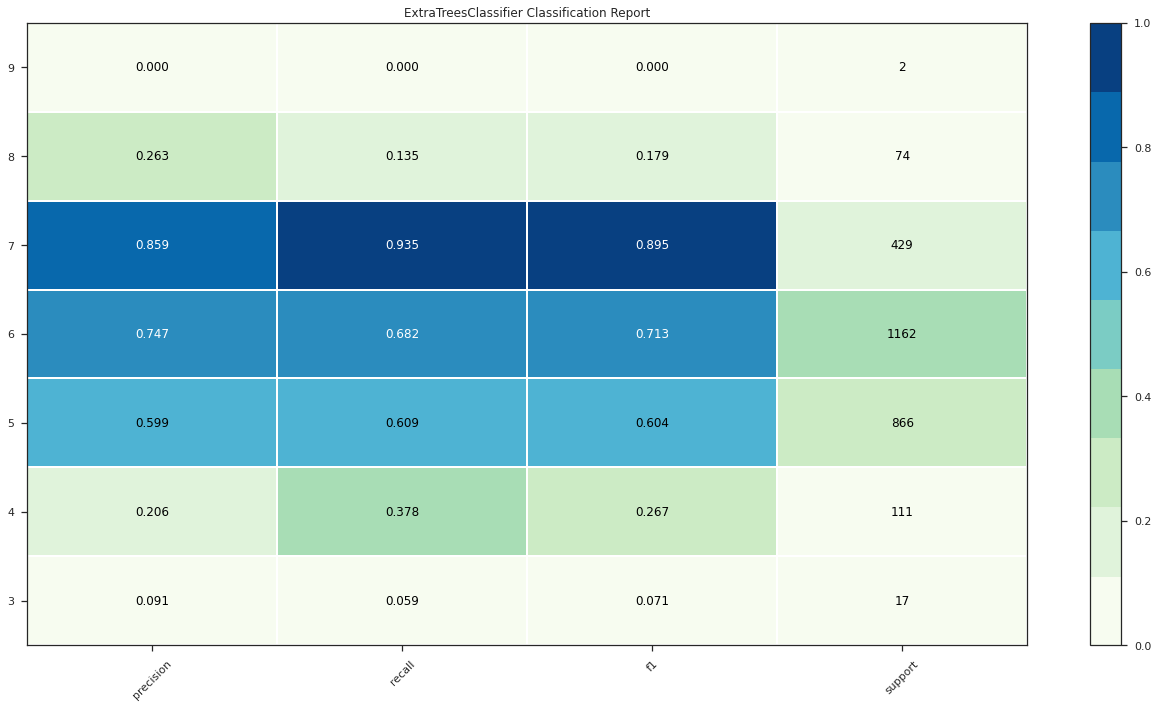

In [30]:
# Relatório do classificador
fig, ax = plt.subplots(figsize=(18, 10))
visualizer = classification_report(
    ExtraTreesClassifier(**params),
    X_train,
    y_train,
    X_test,
    y_test,
    support=True,
    cmap='GnBu'
)

plt.show()

Podemos observar que o modelo consegue identificar bem os padrões para as classes com maiores exemplos, que se encontram na faixa de qualidade entre 5 e 7.

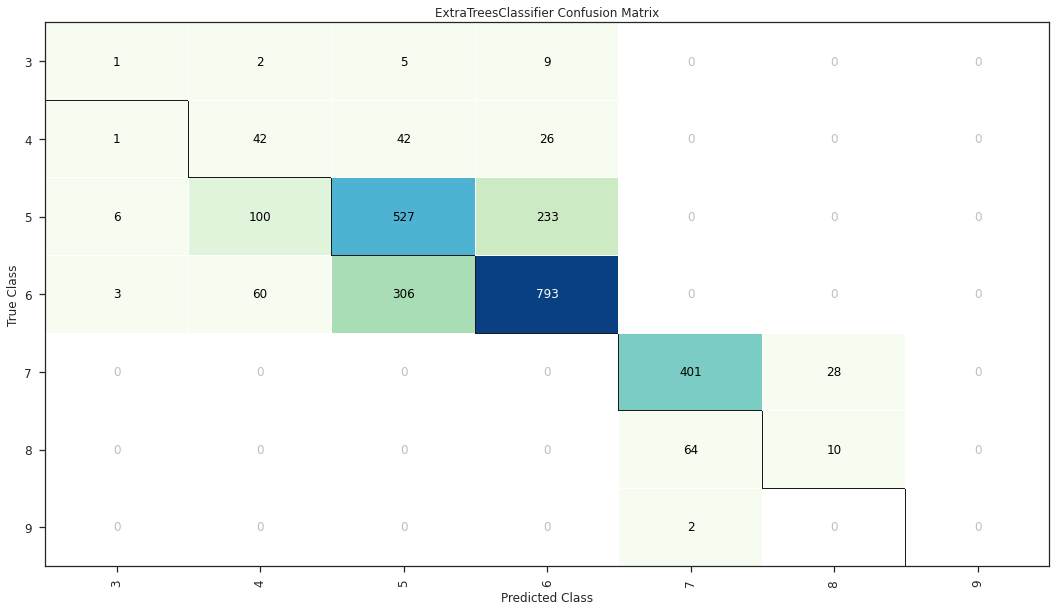

In [31]:
# Matriz de confusão do modelo
fig, ax = plt.subplots(figsize=(18, 10))
visualizer = confusion_matrix(
    ExtraTreesClassifier(**params),
    X_train,
    y_train,
    X_test,
    y_test,
    cmap='GnBu'
)

plt.show()

Na matriz de confusão podemos notar que o modelo não consegue separar bem as classes 5 e 6 da base.

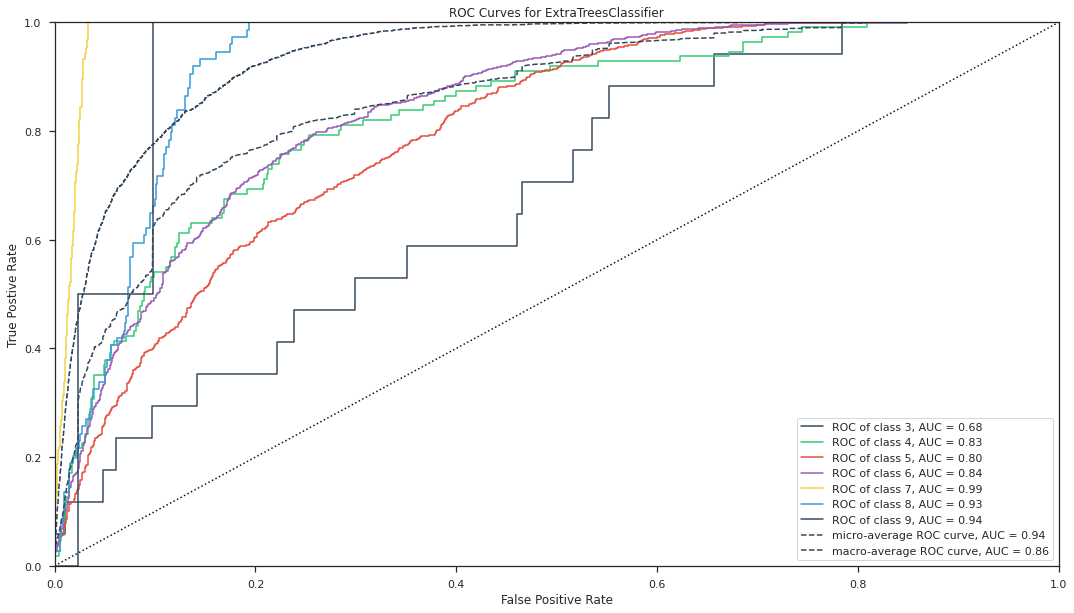

In [32]:
# Curva ROC AUC
fig, ax = plt.subplots(figsize=(18, 10))
visualizer = roc_auc(
    ExtraTreesClassifier(**params),
    X_train,
    y_train,
    X_test,
    y_test
)

plt.show()

Podemos notar um comportamento estranho nos casos em que temos poucos exemplos. Provavelmente o modelo não possui uma boa capacidade de discriminação nas classes 3, 8 e 9.

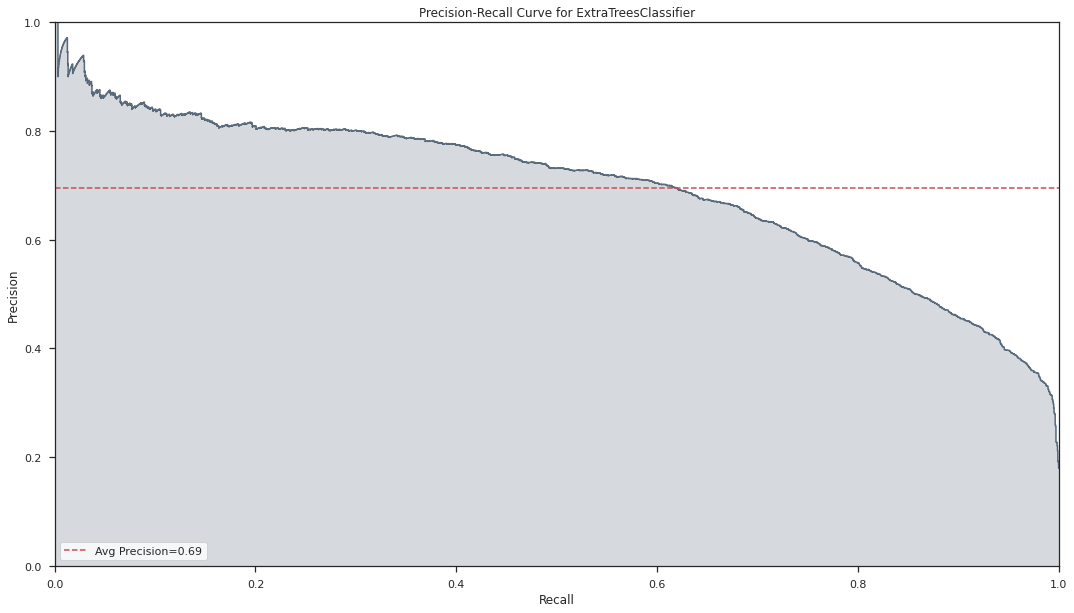

In [33]:
# Curva de Recall
fig, ax = plt.subplots(figsize=(18, 10))
visualizer = precision_recall_curve(
    ExtraTreesClassifier(**params),
    X_train,
    y_train,
    X_test,
    y_test
)

plt.show()

Aqui temos o trade-off entre a precision e o recall do modelo. A área da curva indica que o modelo ainda não é capaz de classificar bem todas as labels.

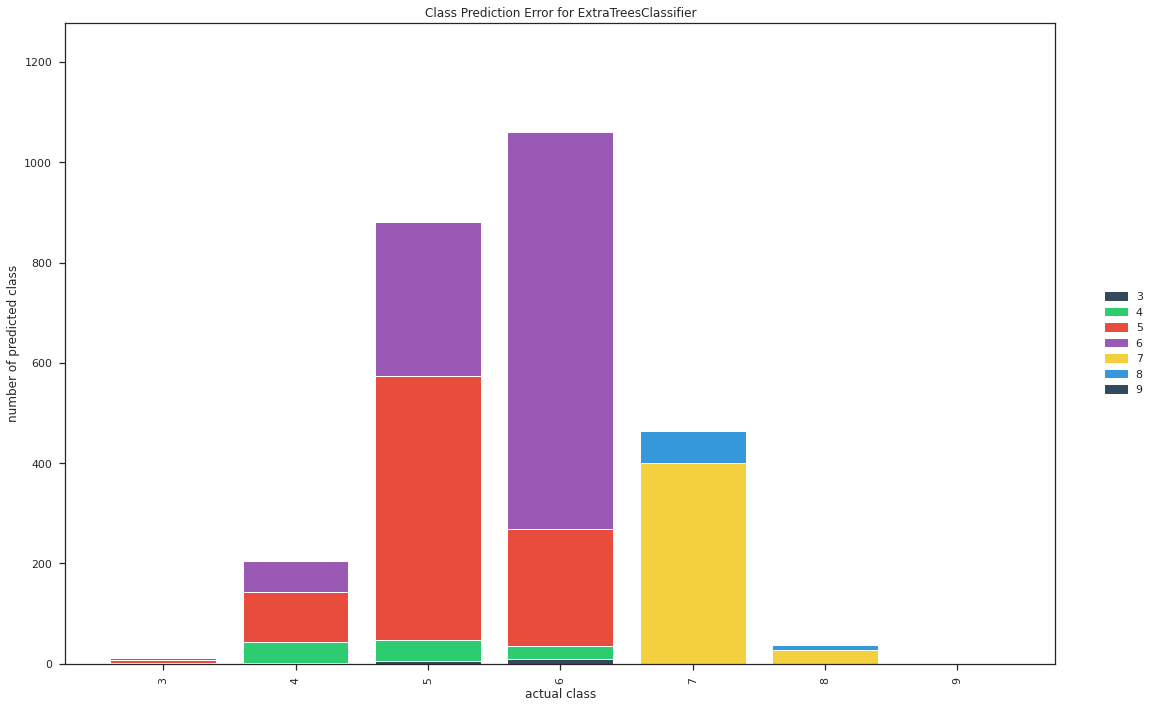

In [34]:
# Gráfico de erros na predição
fig, ax = plt.subplots(figsize=(18, 10))
visualizer = class_prediction_error(
    ExtraTreesClassifier(**params),
    X_train,
    y_train,
    X_test,
    y_test
)

plt.show()

De acordo com a premissa na fase de feature engineering acerca da qualidade dos vinhos, podemos observar uma característica muito clara neste gráfico. Há uma diferença grande entre vinhos de qualidade alta (nota a partir de 7) e os de baixa (até a nota 6). Nos de alta qualidade, temos uma diferença entre as características maior, o que permite o modelo a separar melhor as classes nessa faixa. Já nos de baixa qualidade existe uma correlação alta entre as suas características, degradando o modelo.

### 4.8 Explicabilidade do modelo

In [35]:
%%time
# Classificador otimizado
clf, _ = train_classifier(ExtraTreesClassifier, params, X_train,
                       y_train, X_test, y_test, return_scores=True)

# Cálculo do SHAP values
explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(df[features_columns])

CPU times: user 31min 41s, sys: 296 ms, total: 31min 41s
Wall time: 31min 39s


In [36]:
# Gráfico de força das features
shap.force_plot(
    explainer.expected_value[0],
    pd.DataFrame(shap_values[0], columns=features_columns).median().values,
    feature_names=features_columns,
    link="logit"
)

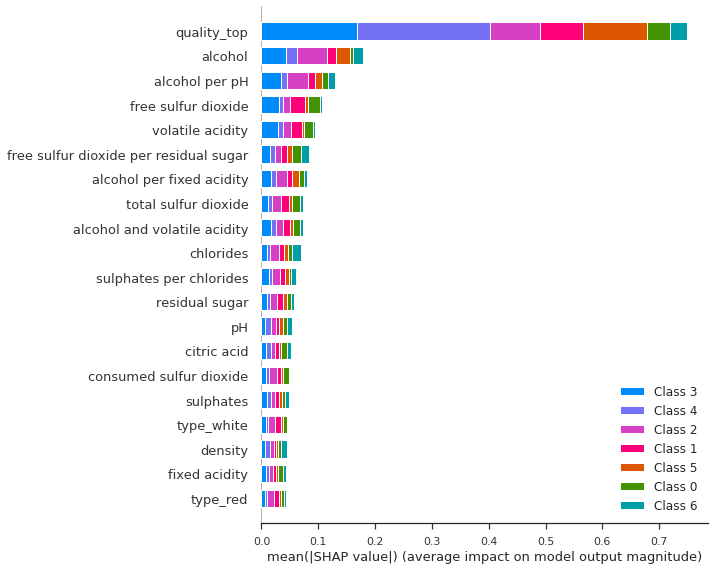

In [37]:
# Gráfico de importância das features no valor SHAP
shap.summary_plot(shap_values, df[features_columns])